# Autoencoder

We inspired our encoder in the one used in CFGEN, which has is a multi-layer perceptron (MLP) with two hidden layers of dimensions
[512, 256] that map the input to a 50-dimensional latent space.

In [2]:
# Autoencoder notebook but not for training just for using to encode and decode

import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset

import numpy as np
from typing import List, Optional, Callable
import torch.nn as nn
import torch.nn.functional as F
from scvi.distributions import NegativeBinomial
import torch.nn.functional as F
import scanpy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# -------------------------------
# Define MLP (like the one in CFGEN)
# -------------------------------
class MLP(nn.Module):
    def __init__(self, 
                 dims: List[int],
                 batch_norm: bool, 
                 dropout: bool, 
                 dropout_p: float, 
                 activation: Optional[Callable] = nn.ELU, 
                 final_activation: Optional[str] = None):
        super().__init__()
        self.dims = dims
        self.batch_norm = batch_norm
        self.activation = activation
        layers = []
        for i in range(len(dims[:-2])):
            block = [nn.Linear(dims[i], dims[i+1])]
            if batch_norm:
                block.append(nn.BatchNorm1d(dims[i+1]))
            block.append(activation())
            if dropout:
                block.append(nn.Dropout(dropout_p))
            layers.append(nn.Sequential(*block))
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)
        if final_activation == "tanh":
            self.final_activation = nn.Tanh()
        elif final_activation == "sigmoid":
            self.final_activation = nn.Sigmoid()
        else:
            self.final_activation = None

    def forward(self, x):
        x = self.net(x)
        return x if self.final_activation is None else self.final_activation(x)

In [4]:

# -------------------------------
# NB Autoencoder
# -------------------------------
class NB_Autoencoder(nn.Module):
    def __init__(self,
                 num_features: int,
                 latent_dim: int = 50,
                 hidden_dims: List[int] = [512, 256],
                 dropout_p: float = 0.1,
                 l2_reg: float = 1e-5,
                 kl_reg: float = 0):
        super().__init__()
        self.num_features = num_features
        self.latent_dim = latent_dim
        self.l2_reg = l2_reg
        self.kl_reg = kl_reg

        self.hidden_encoder = MLP(
        dims=[num_features, *hidden_dims, latent_dim],
        batch_norm=True,
        dropout=False,
        dropout_p=dropout_p
        )
        #self.latent_layer = nn.Linear(hidden_dims[-1], latent_dim)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.decoder = MLP(
            dims=[latent_dim, *hidden_dims[::-1], num_features],
            batch_norm=True,
            dropout=False,
            dropout_p=dropout_p
        )

        #self.log_theta = nn.Parameter(torch.randn(num_features) * 0.01)
        self.theta = torch.nn.Parameter(torch.randn(num_features), requires_grad=True)
    def forward(self, x):
        
        z = self.hidden_encoder(x["X_norm"])
        
        #z = self.latent_layer(h)
        # Raw decoded logits
        logits = self.decoder(z)   # shape (batch, num_genes)
        
        # Softmax over genes → normalized probabilities
        gene_probs = F.softmax(logits, dim=1)
        
        # Library size of each cell (sum of counts)
        library_size = x["X"].sum(1).unsqueeze(1).to(self.device)  # shape (batch, 1)
        
        # Scale probabilities by library size → mean parameter μ
        mu = gene_probs * library_size
 

        #theta = torch.exp(self.log_theta).unsqueeze(0).expand_as(mu)
        return {"z": z, "mu": mu, "theta": self.theta}

    def encode(self, x):
        z = self.hidden_encoder(x)
        return z
        
    def decode(self, z, library_size=None):
        """
        Decode latent vectors z to NB parameters mu, theta.
        z: (batch, latent_dim)
        library_size: (batch, 1) sum of counts per cell; if None, use 1.0
        """
        logits = self.decoder(z)  # (batch, num_genes)
        gene_probs = F.softmax(logits, dim=1)  # softmax over genes
    
        if library_size is None:
            # Use average library size 1.0 if not provided
            library_size = torch.ones(z.size(0), 1, device=z.device)
    
        mu = gene_probs * library_size  # scale by library size
        #theta = torch.exp(self.log_theta).unsqueeze(0).expand_as(mu)
        return {"mu": mu, "theta": self.theta}

    


   

    def loss_function(self, x, outputs):
        """
        Compute loss using scvi NegativeBinomial.
        """
        mu = outputs["mu"]          # (batch, n_genes)
        theta = outputs["theta"]    # (batch, n_genes)
        z = outputs["z"]            # latent
    
        # scvi NegativeBinomial expects mu and theta
        nb_dist = NegativeBinomial(mu=mu, theta=torch.exp(self.theta))
        nll = -nb_dist.log_prob(x).sum(dim=1).mean()  # mean over batch
        
        # Optional regularization
        l2_loss = sum((p**2).sum() for p in self.parameters()) * self.l2_reg
        kl_loss = (z**2).mean() * self.kl_reg
    
        loss = nll + l2_loss + kl_loss
        return {"loss": loss, "nll": nll}


In [5]:
# dataloader

class CountsDataset(Dataset):
    def __init__(self, X, y=None):
        """
        X: raw counts tensor (num_cells, num_genes)
        y: optional labels tensor (num_cells,)
        """
        if hasattr(X, "toarray"):
            X = X.toarray()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.X_norm = torch.log1p(self.X)  # log1p = log(1 + x)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None
        self.n_samples = self.X.shape[0]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = dict(
            X=self.X[idx],
            X_norm=self.X_norm[idx]
        )
        if self.y is not None:
            sample["y"] = self.y[idx]
        return sample




In [6]:
#check if it's corrupted
input_file_path = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train.h5ad"
#adata = ad.read_h5ad("/zhome/99/9/213566/deepL/adata_preprocessed_subset.h5ad", backed='r')
adata = ad.read_h5ad(input_file_path)
adata.obs.head()
X = adata.layers["X_counts"]
if hasattr(X, "toarray"):
    X = X.toarray()
X = torch.tensor(X, dtype=torch.float32)
print(X.shape)
print(X)
log_transformed_x = torch.log1p(X)
print(log_transformed_x)


torch.Size([2110, 8573])
tensor([[0., 0., 5.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 4.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0.0000, 0.0000, 1.7918,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6931, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.6931, 0.0000, 1.6094,  ..., 0.6931, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [16]:
# -------------------------------
# Main training + encoding
# -------------------------------
input_file = input_file_path
latent_dim = 50
hidden_dims = [512, 256]
batch_size = 512
epochs = 1000
learning_rate = 1e-3
epochs_list=[]
loss_list=[]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load data ---
adata = ad.read_h5ad(input_file)

# Load RAW COUNTS
X = adata.layers["X_counts"]
if hasattr(X, "toarray"):
    X = X.toarray()
X = torch.tensor(X, dtype=torch.float32)



dataset = CountsDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- Initialize model ---
num_genes = adata.n_vars
model = NB_Autoencoder(num_features=num_genes,
                       latent_dim=latent_dim,
                       hidden_dims=hidden_dims)
model = model.to(device)
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# --- Training loop ---
for epoch in range(epochs):
    epoch_loss = 0
    for batch in dataloader:
        # Use log-transformed input for encoder
        
        batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}

        # Forward pass
        outputs = model(batch)

        # Compute loss on raw counts
        loss_dict = model.loss_function(batch["X"], outputs)
        loss = loss_dict["loss"]

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        #epoch_loss += loss.item() * x_raw.size(0)
        epoch_loss += loss.item() * batch["X"].size(0)
        

    epoch_loss /= len(dataset)
    epochs_list.append(epoch)
    loss_list.append(epoch_loss)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

# Save trained model
model_file = input_file_path.replace(".h5ad", "_nb_autoencoder.pt")
torch.save(model.state_dict(), model_file)
print(f"Trained model saved to {model_file}")



/tmp/ipykernel_1650309/654953770.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


Epoch 50/1000 - Loss: 2624.8902
Epoch 100/1000 - Loss: 2432.8905
Epoch 150/1000 - Loss: 2270.6122
Epoch 200/1000 - Loss: 2118.3759
Epoch 250/1000 - Loss: 1988.4521
Epoch 300/1000 - Loss: 1879.8087
Epoch 350/1000 - Loss: 1805.1406
Epoch 400/1000 - Loss: 1742.4479
Epoch 450/1000 - Loss: 1701.0725
Epoch 500/1000 - Loss: 1663.3275
Epoch 550/1000 - Loss: 1637.0945
Epoch 600/1000 - Loss: 1612.8231
Epoch 650/1000 - Loss: 1600.9059
Epoch 700/1000 - Loss: 1578.7483
Epoch 750/1000 - Loss: 1565.6815
Epoch 800/1000 - Loss: 1556.6491
Epoch 850/1000 - Loss: 1540.1925
Epoch 900/1000 - Loss: 1534.1782
Epoch 950/1000 - Loss: 1523.6053
Epoch 1000/1000 - Loss: 1513.8035
Trained model saved to /dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train_nb_autoencoder.pt


In [11]:

# --- Save encoded training cells to train flow model---
model.eval()
all_z = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}
        outputs = model.forward(batch)

        z = outputs["z"].cpu().numpy()
        all_z.append(z)

latent = np.concatenate(all_z, axis=0)

# Save to AnnData
adata.obsm["X_latent"] = latent
output_file = input_file.replace(".h5ad", "_with_latent.h5ad")
adata.write(output_file)

print(f"Latent space saved to {output_file}")

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 23.18it/s]


Latent space saved to /dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train_with_latent.h5ad


In [69]:
with torch.no_grad():
    for batch in tqdm(test_loader):
        #size_factor = {"rna": batch["X"]["rna"].sum(1).unsqueeze(1)}
        batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}

        
        outputs = model.forward(batch)
        print(outputs)
        exit()

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.48it/s]

{'z': tensor([[-0.9789,  0.5749,  0.2133,  ..., -0.4244, -2.1209, -0.0483],
        [ 0.8309, -1.8014,  0.7849,  ...,  1.7292, -1.0034, -0.1317],
        [-0.3580, -1.0108,  1.1366,  ...,  1.1616,  0.8975, -0.7494],
        ...,
        [-0.3434, -0.6208,  0.1416,  ...,  0.0049, -1.4370,  0.4863],
        [ 0.4579, -1.4706, -1.0768,  ..., -0.4966,  0.1373,  0.8362],
        [ 0.0422, -1.1814,  1.5015,  ..., -1.1246,  0.0882,  0.2924]],
       device='cuda:0'), 'mu': tensor([[1.4754e-02, 2.9168e-03, 1.1744e-01,  ..., 3.9788e-02, 1.8031e-03,
         1.7223e-05],
        [1.0917e-03, 4.7379e-03, 2.7566e+00,  ..., 5.0757e-02, 1.7644e-02,
         3.9245e-05],
        [2.3570e-03, 5.1180e-04, 4.7714e-02,  ..., 1.9399e-01, 2.1168e-04,
         1.5279e-05],
        ...,
        [3.9776e-03, 8.5954e-02, 2.6465e+00,  ..., 2.3987e-02, 2.9120e-01,
         1.1288e-04],
        [1.1674e-02, 4.6346e-02, 1.8179e+00,  ..., 4.4148e-01, 4.2787e-04,
         1.0940e-04],
        [1.6271e-03, 2.3070e-04

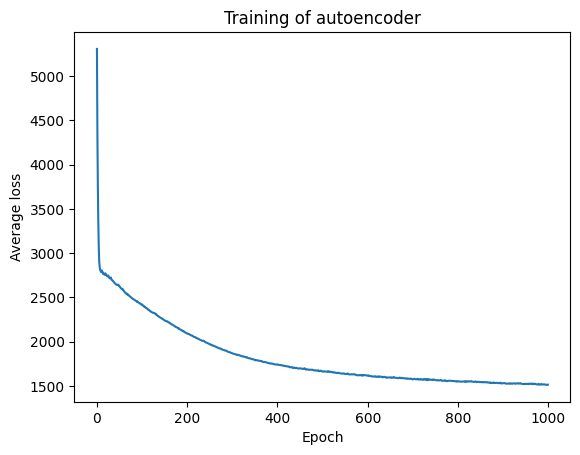

In [42]:
plt.plot(epochs_list, loss_list)
plt.title('Training of autoencoder')
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.show()

In [8]:
# Model parameters must match training
num_genes = 8573  # for example, pbmc3k
latent_dim = 50
hidden_dims = [512, 256]

model_file = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train_nb_autoencoder.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NB_Autoencoder(
    num_features=num_genes,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims
)
model.load_state_dict(torch.load(model_file, map_location=device))
model = model.to(device)
model.eval()  

NB_Autoencoder(
  (hidden_encoder): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=8573, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=50, bias=True)
    )
  )
  (decoder): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=50, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [58]:
# Load counts for testing
adata_test = ad.read_h5ad("/dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_test.h5ad")
X_test = adata_test.layers["X_counts"]

if hasattr(X_test, "toarray"):
    X_test = X_test.toarray()
X_test = torch.tensor(X_test, dtype=torch.float32)

# Create Dataset / DataLoader
test_dataset = CountsDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


/tmp/ipykernel_1627550/2640616511.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


In [59]:
X_merged = []
labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        #size_factor = {"rna": batch["X"]["rna"].sum(1).unsqueeze(1)}
        batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}
        outputs = model.forward(batch)
        mu_hat = outputs["mu"]
        X_hat = NegativeBinomial(mu=mu_hat, theta=torch.exp(model.theta)).sample() # We <3 Mikkel

        X_merged.append(batch["X"].cpu().numpy())
        X_merged.append(X_hat.cpu().numpy())
        labels.extend(["Real" for _ in range(len(batch["X"]))])
        labels.extend(["Generated" for _ in range(len(X_hat))])

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 38.38it/s]


In [60]:
X_merged = np.concatenate(X_merged)

In [61]:
adata = sc.AnnData(X=X_merged, 
                   obs={"dataset_type": labels})

In [62]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

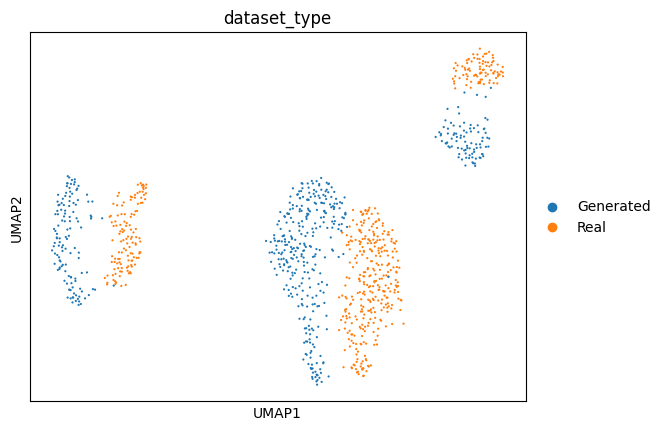

In [64]:
sc.pl.umap(adata, color="dataset_type", s=10, save="autoencoder_test_umap_w_reg.png")

In [ ]:
# X_merged = []
# labels = []
# from tqdm import tqdm
# model.eval()
# device = next(model.parameters()).device
# latent_noise_scale = 0.05
# with torch.no_grad():
#     for batch in tqdm(test_loader):
#         x_raw = batch["X"].to(device)
#         x_norm = batch["X_norm"].to(device)

#         # Encode + decode
#         z = model.encode(x_norm)
#         z_noisy = z + torch.randn_like(z) * latent_noise_scale
        
#         library_size = x_raw.sum(1).unsqueeze(1)
#         outputs = model.decode(z_noisy, library_size)
#         mu_hat = outputs["mu"]
#         theta = torch.exp(outputs["theta"])

#         # Convert mu, theta → PyTorch NB parameters
#         total_count = theta
#         probs = total_count / (mu_hat + total_count)
#         nb_dist = NegativeBinomial(total_count=total_count, probs=probs)
#         X_hat = nb_dist.sample()

#         # --- Ensure 2D arrays before appending ---
#         x_real = x_raw.cpu().numpy()
#         if x_real.ndim == 1:
#             x_real = x_real[np.newaxis, :]  # shape (1, n_genes)

#         x_fake = X_hat.cpu().numpy()
#         if x_fake.ndim == 1:
#             x_fake = x_fake[np.newaxis, :]  # shape (1, n_genes)

#         X_merged.append(x_real)
#         X_merged.append(x_fake)
#         labels.extend(["Real"] * x_real.shape[0])
#         labels.extend(["Generated"] * x_fake.shape[0])

# # Combine batches
# X_merged = np.concatenate(X_merged, axis=0)
# labels = np.array(labels)

# print("X_merged shape:", X_merged.shape)
# print("labels shape:", labels.shape)


In [ ]:

# # --- Build AnnData object ---
# adata = sc.AnnData(X=X_merged, obs={"dataset_type": labels})

# # --- Preprocessing ---
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# # --- Dimensionality reduction ---
# sc.tl.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

# # --- Visualization ---
# import matplotlib.pyplot as plt
# sc.pl.umap(adata, color="dataset_type", s=10, show=True)
# plt.show()  # ensures the figure is displayed
# sc.pl.umap(adata, color="dataset_type", s=10, show=False, save="_real_vs_generated.png")


In [ ]:
print("theta range:", torch.exp(model.theta).min(), torch.exp(model.theta).max())
